# Régression sans inversion

Ce notebook mesure le temps de calcul dans deux algorithmes pour résoudre une régression linéaire, le premier inverse un matrice, le second le fait sans inverser une matrice, le troisième reprend l'idée du second mais utilise une décomposition [QR](https://fr.wikipedia.org/wiki/D%C3%A9composition_QR) puis inverse la matrice *R*.

In [1]:
%matplotlib inline

In [2]:
import numpy.random as rnd
X = rnd.randn(1000, 7)
eps = rnd.randn(1000, 1) / 3
y = X.sum(axis=1).reshape((X.shape[0], 1)) + eps
X.shape, y.shape, eps.shape

((1000, 7), (1000, 1), (1000, 1))

In [3]:
from mlstatpy.ml.matrices import linear_regression, gram_schmidt
beta1 = linear_regression(X, y, algo=None)
beta2 = linear_regression(X, y, algo="gram")
beta1, beta2

C:\xavierdupre\__home_\GitHub\mlstatpy\src\mlstatpy\ml\matrices.py:116: UserWarning: This function is not tested for a multidimensional linear regression.
  "This function is not tested for a multidimensional linear regression.")


(array([[1.00192287],
        [0.99972897],
        [0.99481888],
        [0.99599058],
        [0.99952219],
        [0.99775479],
        [1.0099302 ]]),
 array([1.00192287, 0.99972897, 0.99481888, 0.99599058, 0.99952219,
        0.99775479, 1.0099302 ]))

In [4]:
%timeit linear_regression(X, y, algo=None)

38.7 µs ± 2.25 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [5]:
%timeit linear_regression(X, y, algo="gram")

311 µs ± 19.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
%timeit linear_regression(X, y, algo="qr")

135 µs ± 1.77 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
Xt = X.T
%timeit gram_schmidt(Xt)

215 µs ± 7.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Un exemple avec [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [8]:
from sklearn.linear_model import LinearRegression
clr = LinearRegression()
%timeit clr.fit(X, y)

421 µs ± 9.56 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Qui utilise la fonction [lstsq](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html?highlight=lstsq):

In [9]:
from numpy.linalg import lstsq
%timeit lstsq(X, y, rcond=None)

73 µs ± 3.44 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Il serait sans doute possible d'optimiser les calculs en réduisant le nombre de copie et de transposées. La version utilisant une décomposition [QR](https://fr.wikipedia.org/wiki/D%C3%A9composition_QR) est assez rapide. Le code est là [matrices.py](https://github.com/sdpython/mlstatpy/blob/master/src/mlstatpy/ml/matrices.py). Pour dépasser [numpy](https://www.numpy.org/), il faut passer au C++. *scikit-learn* ajoute des étapes intermédiaires pour vérifier les données ce qui explique la longueur. On résume le tout par un graphique.

In [10]:
from cpyquickhelper.numbers import measure_time

In [11]:
stmts = [dict(name='lr_matrix', fct="linear_regression(X, y, algo=None)"),
         dict(name='lr_gram', fct="linear_regression(X, y, algo='gram')"),
         dict(name='lr_qr', fct="linear_regression(X, y, algo='qr')"),
         dict(name='gram', fct="gram_schmidt(Xt)"),
         dict(name='sklearn', fct="clr.fit(X, y)"),
         dict(name='lstsq', fct="lstsq(X, y)")]

memo = []
for size, dim in [(100, 10), (1000, 10), (10000, 10),
                  (100, 20), (1000, 20), (10000, 20),
                  (100, 50), (1000, 50)]:
    print(size, dim)
    X = rnd.randn(size, dim)
    eps = rnd.randn(size, 1) / 3
    y = X.sum(axis=1).reshape((X.shape[0], 1)) + eps
    y = y.ravel()
    context = dict(linear_regression=linear_regression, Xt=X.T,
                   X=X, y=y, gram_schmidt=gram_schmidt, clr=clr,
                   lstsq=lambda X, y: lstsq(X, y, rcond=None))
    
    for stmt in stmts:
        res = measure_time(stmt['fct'], number=20, repeat=20, div_by_number=True, context=context)
        res.update(stmt)
        res['size'] = size
        res['dim'] = dim
        memo.append(res)

import pandas
df = pandas.DataFrame(memo)
df.head()

100 10
1000 10
10000 10
100 20
1000 20
10000 20
100 50
1000 50


,average,context_size,deviation,dim,fct,max_exec,min_exec,name,number,repeat,size
0,0.000043,368,0.000023,10,"linear_regression(X, y, algo=None)",0.000133,0.000026,lr_matrix,20,20,100
1,0.000393,368,0.000086,10,"linear_regression(X, y, algo='gram')",0.000706,0.000317,lr_gram,20,20,100
2,0.000114,368,0.000013,10,"linear_regression(X, y, algo='qr')",0.000140,0.000094,lr_qr,20,20,100
3,0.000239,368,0.000020,10,gram_schmidt(Xt),0.000261,0.000189,gram,20,20,100
4,0.000397,368,0.000035,10,"clr.fit(X, y)",0.000461,0.000347,sklearn,20,20,100


In [12]:
piv = pandas.pivot_table(df, index=['size', 'dim'], columns='name', values='average')
piv

name           gram   lr_gram  lr_matrix     lr_qr     lstsq   sklearn
size  dim                                                             
100   10   0.000239  0.000393   0.000043  0.000114  0.000078  0.000397
      20   0.000434  0.000756   0.000076  0.000139  0.000145  0.000447
      50   0.001334  0.002270   0.000111  0.000296  0.000561  0.000842
1000  10   0.000328  0.000506   0.000063  0.000168  0.000164  0.000551
      20   0.000809  0.001194   0.000093  0.000331  0.000232  0.000676
      50   0.003082  0.003990   0.000215  0.000939  0.000937  0.001500
10000 10   0.001110  0.001327   0.000278  0.002265  0.000449  0.001550
      20   0.009668  0.010536   0.000281  0.005739  0.002124  0.005675

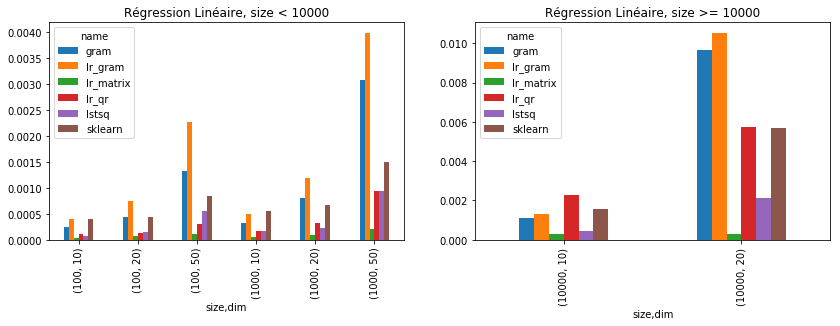

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14,4))
piv[:6].plot(kind="bar", ax=ax[0])
piv[6:].plot(kind="bar", ax=ax[1])
ax[0].set_title("Régression Linéaire, size < 10000")
ax[1].set_title("Régression Linéaire, size >= 10000");

## Streaming versions

L'idée est différente ici puisqu'il s'agit de calculer toutes les régressions linéaires intermédiaires. Les algorithmes sont décrits par l'exposé [Régression linéaire par morceaux](find://l-reglin-piecewise-streaming).

In [48]:
from mlstatpy.ml.matrices import streaming_linear_regression, streaming_linear_regression_gram_schmidt

def all_linear_regression(X, y):
    for i in range(X.shape[1], X.shape[0]):
        yield linear_regression(X[:i], y[:i])

stmts = [dict(name='lr_matrix', fct="list(all_linear_regression(X, y))"),
         dict(name='lr_st_mat', fct="list(streaming_linear_regression(X, y))"),
         dict(name='lr_st_gram', fct="list(streaming_linear_regression_gram_schmidt(X, y))"),
        ]

memo = []
for dim in (10, ):
    for size in range(100, 3500, 500):
        print(size, dim)
        X = rnd.randn(size, dim)
        eps = rnd.randn(size, 1) / 3
        y = X.sum(axis=1).reshape((X.shape[0], 1)) + eps
        y = y.ravel()
        context = dict(X=X, y=y,
                       all_linear_regression=all_linear_regression,
                       streaming_linear_regression=streaming_linear_regression,
                       streaming_linear_regression_gram_schmidt=streaming_linear_regression_gram_schmidt)

        for stmt in stmts:
            if "gram" in stmt['name']:
                nn = 1
                if size >= 1000:
                    continue
            else:
                nn = 5
            res = measure_time(stmt['fct'], number=nn, repeat=nn, div_by_number=True, context=context)
            res.update(stmt)
            res['size'] = size
            res['dim'] = dim
            memo.append(res)

import pandas
df = pandas.DataFrame(memo)
df.head()

100 10
600 10
1100 10
1600 10
2100 10
2600 10
3100 10


,average,context_size,deviation,dim,fct,max_exec,min_exec,name,number,repeat,size
0,0.003108,368,0.000433,10,"list(all_linear_regression(X, y))",0.003602,0.002449,lr_matrix,5,5,100
1,0.003103,368,0.000432,10,"list(streaming_linear_regression(X, y))",0.003921,0.002749,lr_st_mat,5,5,100
2,0.048359,368,0.000000,10,list(streaming_linear_regression_gram_schmidt(...,0.048359,0.048359,lr_st_gram,1,1,100
3,0.019216,368,0.001044,10,"list(all_linear_regression(X, y))",0.020197,0.017347,lr_matrix,5,5,600
4,0.019794,368,0.001421,10,"list(streaming_linear_regression(X, y))",0.022027,0.017918,lr_st_mat,5,5,600


In [49]:
piv = pandas.pivot_table(df, index=['size', 'dim'], columns='name', values='average')
piv

,name,lr_matrix,lr_st_gram,lr_st_mat
size,dim,,,
100,10,0.003108,0.048359,0.003103
600,10,0.019216,0.322083,0.019794
1100,10,0.038827,NaN,0.032701
1600,10,0.069561,NaN,0.056168
2100,10,0.102831,NaN,0.071988
2600,10,0.145529,NaN,0.110444
3100,10,0.195744,NaN,0.115468


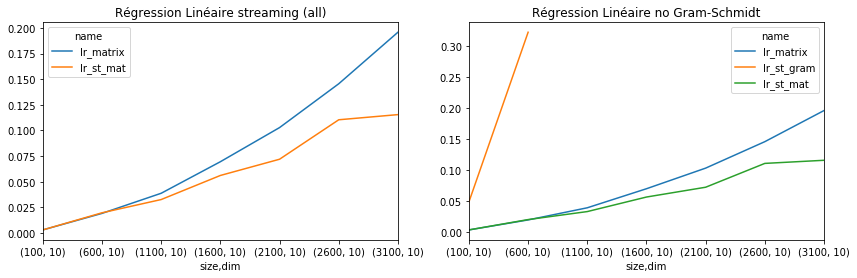

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
piv[["lr_matrix", "lr_st_mat"]].plot(ax=ax[0])
piv.plot(ax=ax[1])
ax[0].set_title("Régression Linéaire streaming (all)")
ax[1].set_title("Régression Linéaire no Gram-Schmidt");

La version streaming devient plus intéressante à partir de 1000 observations, le coût en linéaire en *N* contrairement à la version classique qui est en $N^2$. La version Gram-Schmidt devrait être réécrite en C++ pour proposer des temps comparables.